<a href="https://colab.research.google.com/github/pullz6/RUL_Prediction/blob/DR/NASA_Engine_RUL_Predictions_with_DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#Importing all the models
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor

#Importing the datasets
drive.mount('/content/drive')
df_engine_test1 = pd.read_csv('/content/drive/My Drive/sample_data/Projects/NASA-Engine-Safety/test_FD001.txt', sep = "\s+", header = None)
df_engine_test2 = pd.read_csv('/content/drive/My Drive/sample_data/Projects/NASA-Engine-Safety/test_FD002.txt', sep = "\s+", header = None)
df_engine_test3 = pd.read_csv('/content/drive/My Drive/sample_data/Projects/NASA-Engine-Safety/test_FD003.txt', sep = "\s+", header = None)
df_engine_test4 = pd.read_csv('/content/drive/My Drive/sample_data/Projects/NASA-Engine-Safety/test_FD004.txt', sep = "\s+", header = None)

df_engine_train1 = pd.read_csv('/content/drive/My Drive/sample_data/Projects/NASA-Engine-Safety/train_FD001.txt', sep = "\s+", header = None)
df_engine_train2 = pd.read_csv('/content/drive/My Drive/sample_data/Projects/NASA-Engine-Safety/train_FD002.txt', sep = "\s+", header = None)
df_engine_train3 = pd.read_csv('/content/drive/My Drive/sample_data/Projects/NASA-Engine-Safety/train_FD003.txt', sep = "\s+", header = None)
df_engine_train4 = pd.read_csv('/content/drive/My Drive/sample_data/Projects/NASA-Engine-Safety/train_FD004.txt', sep = "\s+", header = None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#Creating dataframes
frames = [df_engine_test1,df_engine_test2,df_engine_test3,df_engine_test4]
frames_train = [df_engine_train1,df_engine_train2,df_engine_train3,df_engine_train4]
df_engine_test = pd.concat(frames,ignore_index=True)
df_engine_train = pd.concat(frames_train,ignore_index=True)

In [15]:
df_engine_train.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [16]:
df_engine_test.columns = ['Unit Number', 'Time (Cycles)','operational setting 1','operational setting 2','operational setting 3','sensor measurement 1','sensor measurement 2','sensor measurement 3','sensor measurement 4','sensor measurement 5','sensor measurement 6','sensor measurement 7','sensor measurement 8','sensor measurement 9','sensor measurement 10','sensor measurement 11','sensor measurement 12','sensor measurement 13','sensor measurement 14','sensor measurement 15','sensor measurement 16','sensor measurement 17','sensor measurement 18','sensor measurement 19','sensor measurement 20','sensor measurement 21']
df_engine_train.columns = ['Unit Number', 'Time (Cycles)','operational setting 1','operational setting 2','operational setting 3','sensor measurement 1','sensor measurement 2','sensor measurement 3','sensor measurement 4','sensor measurement 5','sensor measurement 6','sensor measurement 7','sensor measurement 8','sensor measurement 9','sensor measurement 10','sensor measurement 11','sensor measurement 12','sensor measurement 13','sensor measurement 14','sensor measurement 15','sensor measurement 16','sensor measurement 17','sensor measurement 18','sensor measurement 19','sensor measurement 20','sensor measurement 21']

In [17]:
def add_RUL (dataset):
  """This functiona calculates the remaining useful life """
  max_time_cycles = dataset.groupby(by='Unit Number')['Time (Cycles)'].max()
  dataset = dataset.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='Unit Number',right_index=True)
  dataset["RUL"] = dataset["max_time_cycle"] - dataset['Time (Cycles)']
  dataset = dataset.drop("max_time_cycle", axis=1)
  return dataset

df_engine_test = add_RUL(df_engine_test)
df_engine_train = add_RUL(df_engine_train)

In [27]:
df_engine_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160359 entries, 0 to 74389
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unit Number            160359 non-null  int64  
 1   Time (Cycles)          160359 non-null  int64  
 2   operational setting 1  160359 non-null  float64
 3   operational setting 2  160359 non-null  float64
 4   operational setting 3  160359 non-null  float64
 5   sensor measurement 1   160359 non-null  float64
 6   sensor measurement 2   160359 non-null  float64
 7   sensor measurement 3   160359 non-null  float64
 8   sensor measurement 4   160359 non-null  float64
 9   sensor measurement 5   160359 non-null  float64
 10  sensor measurement 6   160359 non-null  float64
 11  sensor measurement 7   160359 non-null  float64
 12  sensor measurement 8   160359 non-null  float64
 13  sensor measurement 9   160359 non-null  float64
 14  sensor measurement 10  160359 non-nul

In [30]:
X = df_engine_train.iloc[:, 0:24]
Y = df_engine_train['RUL']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

In [33]:
clf = RandomForestRegressor()

In [34]:
clf.fit(X_train,y_train)

RandomForestRegressor()

In [36]:
y_pred = clf.predict(X_test)

In [40]:
features = ['Unit Number', 'Time (Cycles)','operational setting 1','operational setting 2','operational setting 3','sensor measurement 1','sensor measurement 2','sensor measurement 3','sensor measurement 4','sensor measurement 5','sensor measurement 6','sensor measurement 7','sensor measurement 8','sensor measurement 9','sensor measurement 10','sensor measurement 11','sensor measurement 12','sensor measurement 13','sensor measurement 14','sensor measurement 15','sensor measurement 16','sensor measurement 17','sensor measurement 18','sensor measurement 19','sensor measurement 20','sensor measurement 21']

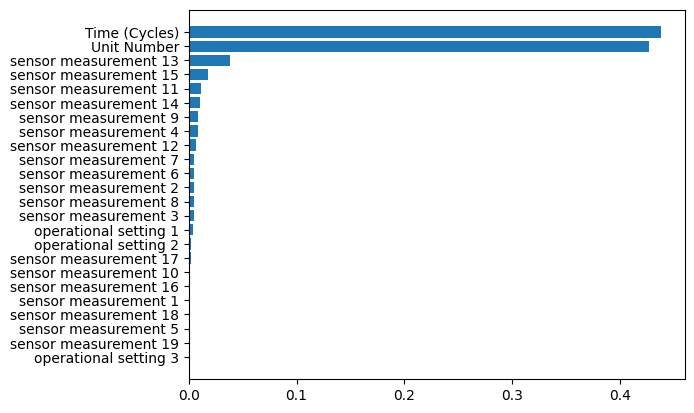

In [41]:
f_i = list(zip(features,clf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.show()